# Watch Dealer
### Programmers: Tom McKenzie, Eddy Nassif
### Class: Data Mining, Spring 2019
### Final Project



# Getting Started
Our project aims to help consumers find the best deals on a given product based on previous price history and it’s trend for the past 90 days. We will be focusing on Rolex wristwatches, and will be using a variety of classification methods to help forecast pricing and ultimately decide whether or not the price for a current listing is a good or bad deal. The dataset will be created by using Ebay’s API to get data on previously sold listings. 

## The Data
We will be acquiring our data using Ebay's API. This API is easy to use and makes grabbing previous sales easy! However, no dataset is perfect, and we had to go through hefty pre-processing to get the data reaedy. There were three steps to our data collection: Gathering, Cleaning, and Classifying.

#### Gathering the data:
Like we said earlier, data gathering was completed using Ebay's API. [Here](https://developer.ebay.com/docs) is a link to the documentation if you want to investigate further.


Below is the function we used to send a response to Ebay's API. As you can see, we pass in some keywords, sort the results from newest to oldest, ask for 100 entries per page, give it a page number, and a minimum and maximum price for previously sold listings. We use minimum and maximum price as a screen for watch parts and accessories. By setting a mininum price at a level that no Rolex will go under, we save a lot of time in cleaning.

In [7]:
def response(Keywords, pageNum, minPrice, maxPrice, api):
    response = api.execute('findCompletedItems', {
        'keywords': Keywords,
        'sortOrder': 'EndTimeLatest',
        'paginationInput': {'entriesPerPage': '100',
                            'pageNumber': pageNum},
        'itemFilter': [
            # {'name': 'Condition', 'value': condition},
            {'name': 'SoldItemsOnly', 'value': True},
            {'name': 'MinPrice', 'value': minPrice},
            {'name': 'MaxPrice', 'value': maxPrice}
        ]
    }
                           )
    return response

As with any API, you need an API Key. We are sharing an API key, and we will be including ours as a means of demonstration. If you would like to try this project for yourself, please register for your own API key.

In [22]:
from ebaysdk.finding import Connection as finding
api = finding(appid='EddyNass-Scraper-PRD-651ca6568-7ae32d61', config_file=None)

Now that we have set the parameters for the API, we can send a request! Let's gather all the items on the first four pages, 400 items in total.

In [21]:
from bs4 import BeautifulSoup

Keywords = "Rolex Wristwatch"
minPrice = 3000
maxPrice = 12000
pageNum = 1
# Collect all items from ebay on page1 through 4
while pageNum <= 4:
    soup = BeautifulSoup(response(Keywords, pageNum, minPrice, maxPrice, api).content, 'lxml')
    if pageNum == 1:
        items = soup.find_all('item')
    else:
        items += soup.find_all('item')
    pageNum += 1
items[:1]

[<item><itemid>254217635900</itemid><title>2005 Unique Rolex Explorer 114270 Black PVD / DLC</title><globalid>EBAY-US</globalid><primarycategory><categoryid>31387</categoryid><categoryname>Wristwatches</categoryname></primarycategory><galleryurl>http://thumbs1.ebaystatic.com/m/mpdOrwj6IVbG2M_ae6sI2cg/140.jpg</galleryurl><viewitemurl>http://www.ebay.com/itm/2005-Unique-Rolex-Explorer-114270-Black-PVD-DLC-/254217635900</viewitemurl><paymentmethod>PayPal</paymentmethod><autopay>false</autopay><postalcode>33132</postalcode><location>Miami,FL,USA</location><country>US</country><shippinginfo><shippingservicecost currencyid="USD">65.0</shippingservicecost><shippingtype>Flat</shippingtype><shiptolocations>Worldwide</shiptolocations><expeditedshipping>true</expeditedshipping><onedayshippingavailable>false</onedayshippingavailable><handlingtime>2</handlingtime></shippinginfo><sellingstatus><currentprice currencyid="USD">4050.0</currentprice><convertedcurrentprice currencyid="USD">4050.0</convert

Ew! The result doesn't look too pretty! We even had to shorten it significantly so it didn't take up the whole notebook! What's happening here is that "items" is collecting all of the information that Ebay is sending us, but we can parse it out using BeautifulSoup. To keep only the necessary attributes, we wrote a function called get_attribtues. Note: Collecting this data takes a long time to run, about 15 minutes. Since it takes so long to run, we will only be using the first few lines in the Jupyter Notebook, but our project comes with an already compiled data set.

In [42]:
def get_attributes(items, index, df):
    for item in items[:3]:
        price = int(round(float(item.currentprice.string)))
        dateSold = item.endtime.string
        dt = parse(dateSold)
        date = dt.date()
        url = item.viewitemurl.string.lower()
        cond = item.conditiondisplayname.string.lower()
        listingType = item.listingtype.string
        start = item.starttime.string
        dt = parse(start)
        start = dt.date()

        # movement, brand, case material, and band material attributes for each item
        # if the attributes are left out of the e-bay pages ITEM SPECIFICS then they
        # will be returned as NULL

        MPN = get_details(get_page(url), "MPN:")
        movement = get_details(get_page(url), "Movement:")
        model = get_details(get_page(url), "Model:")
        case_material = get_details(get_page(url), "Case Material:")
        band_material = get_details(get_page(url), "Band Material:")

        try:
            shipping = int(round(float(item.shippingservicecost.string)))
            total = price + shipping
        except:
            total = price

        # push data to df
        df.loc[index] = [date, total, price, cond, MPN, movement, case_material, band_material, model, listingType,
                         start, url]
        index += 1

    return df

get_attributes uses get_details, which is used to search the item description and extract attributes such as model, case material, etc. These are attributes we could not extract with the api alone. Get_details also calls get_page, which requests the URL and makes it ready to parse the html. 

In [43]:
def get_page(url):
    response = requests.get(url, headers={'Connection': 'close'})
    soup = BeautifulSoup(response.text, 'lxml')
    return soup


def get_details(url, att_name):
    att_description = "NULL"
    data = []
    table = url.find(attrs={'class': 'section'})
    if table is not None:
        rows = table.findAll('tr')
        for row in rows:
            cols = row.findAll('td')
            cols = [ele.text.strip() for ele in cols]
            data.append([ele for ele in cols if ele])
    for i in data:
        if i[:1] == [att_name]:
            att_description = i[1]
        elif i[2:3] == [att_name]:
            att_description = i[3]

    return att_description

When we run our items through get_attributes, the results are much more neat!

In [44]:
import pandas as pd
from dateutil.parser import parse

index = 0
# Declare data frame
df = pd.DataFrame(columns=('date', 'total', 'price', 'condition', 'MPN', 'movement', 'case material',
                           'band material', 'model', 'listingType', 'start', 'url'), dtype=float)

df = get_attributes(items, index, df)
df

,date,total,price,condition,MPN,movement,case material,band material,model,listingType,start,url
0,2019-05-09,4115.0,4050.0,pre-owned,114270,Mechanical (Automatic),Stainless Steel,Stainless Steel,Rolex Explorer,Auction,2019-05-02,http://www.ebay.com/itm/2005-unique-rolex-expl...
1,2019-05-09,5965.0,5900.0,pre-owned,16233,Mechanical (Automatic),Stainless Steel & 18K Gold,Stainless Steel & 18K Gold,Datejust,Auction,2019-05-02,http://www.ebay.com/itm/2001-rolex-16238-datej...
2,2019-05-09,7600.0,7600.0,pre-owned,Does Not Apply,Swiss Automatic,Stainless Steel,Stainless Steel,Submariner,FixedPrice,2019-04-11,http://www.ebay.com/itm/rolex-submariner-16610...


As you can see, this data looks a lot better! This is the basic method we used for gathering our data. Next, we had to clean the data.

### Cleaning the Data
The main issue with our data was the model number. To classify the data appropriately, we needed consistent model names throughout the dataset. Unfortunately, this doesn't look so pretty. We needed to account for every possible misspelling or variation for each name, and correct it. This process needed to be repeated for the model name, band material, and watch movement. Common mistakes would be just saying "plat" instead of platinum for the band material, or Datejust 2 instead of Datejust II. 

To tackle this issue, we changed all words to lowercase using casefold(), then used if else statements to correct and check for incorrect values. Example code looks like this:

In [46]:
def clean_case_material(case_col):
    clean_case_col = []
    for i in case_col:
        if "plati".casefold() in i.casefold():
            clean_case_col.append('Platinum')
        elif "14".casefold() in i.casefold():
            clean_case_col.append('14k Gold')

We ran a variation of the above code for every possible model, movement, and band material we could find. After the attributes were normalized, we were able to join the cleaned dataset with our market value dataset and be classified.

### Classifying the Data
When you purchase something, the person selling you the item won't tell you if you are getting a good or bad deal. It is up to the customer to decide. However, when we are trying to build a classifier for watch valuation, we need to agree on what is a good and bad deal. To set market values, we used [Bob's Watches](https://www.bobswatches.com/used-rolex-prices) as a baseline for whether or not the ebay sale was a good or bad deal. 

After downloading the Bob's Watches dataset, we were able to use that dataset with our cleaned ebay dataset and classify each listing as a good or bad deal.

In [48]:
def classify_deal():
    table = u.read_csv('rolex_prices_data.csv')

    price_col = u.get_column(table,1)

    clean_prices = []
    for price in price_col:
        price = price.replace(',', '')
        price = price.replace('$', '')
        
        clean_prices.append(price)

    clean_table = []
    count = 0
    for row in table:
        clean_table.append([row[0], clean_prices[count]])
        count = count + 1

    u.write_to_file(clean_table, 'rolex_prices_data_clean.csv')

## Visualizing the Data
Visualizing the data helps us better understand the dataset we are working with. By creating different graphs, we get to visualize metrics like the common watch model, median watch price, etc.

### Most Common Watch Models
To visualize the most common watch models, we used a histogram. The code takes in the data, counts the frequency of each watch model, then displays the results on a histogram.

Text(0.5,0,'Model')

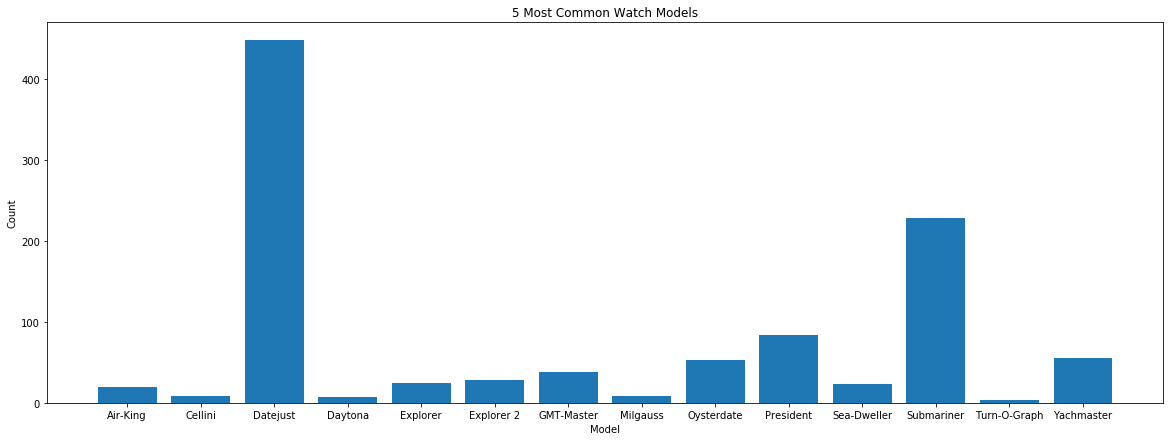

In [55]:
import matplotlib.pyplot as plt
import utils as u
import operator

# Variables
myList = u.read_csv('final_training_dataset.csv')
attribute = 'model'
title = '5 Most Common Watch Models'
xlabel = 'Count'
ylabel = 'Model'

plt.figure(figsize=(20, 7))
data = myList[1:]
col_index = u.get_index(myList, attribute)
x, y = u.get_frequencies(data, col_index)

plt.bar(x, y)
plt.title(title.title())
plt.ylabel(xlabel.title())
plt.xlabel(ylabel.title())

Looks like the Datejust is the most popular watch, followed by the Submariner. This makes sense, because these two models are the more inexpensive rolex models, and the Datejust comes in many varieties while the Submariner is regarded as one of the best "beginner" watches. To analyze watch prices, we used a scatter plot. This helps us identify the outliers and see where most watches are priced.  

NameError: name 'label_plt' is not defined

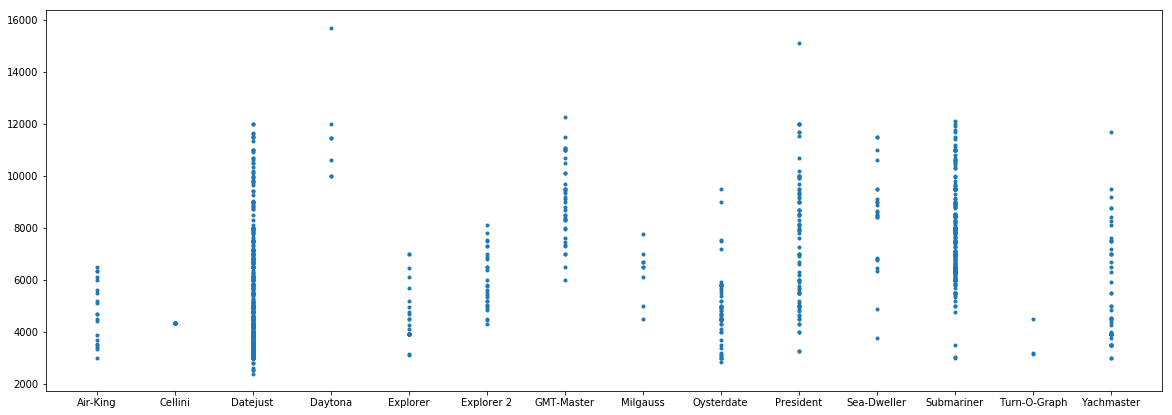

In [56]:
import matplotlib.pyplot as plt
import utils as u
import operator

# Variables
myList = u.read_csv('final_training_dataset.csv')
attributeX = 'model'
attributeY = 'price'
title = 'Watch Prices'
xlabel = 'Model'
ylabel = 'Price'

plt.figure(figsize=(20, 7))
data = myList[1:]
x = u.get_values(data, u.get_index(myList, attributeX))
y = u.get_values(data, u.get_index(myList, attributeY))
plt.scatter(x, y, marker='.')
plt.close()

## Analyzing the Data

Now that we have a clean data set, we can use different classification methods to analyze the data. Let's start with really basic classifiers, Zero-R and Random Selection. Both of these classifiers can be found in "wild_card_classifiers.py"

### Wild Card Classifiers
#### Zero-R
Zero-R was selected to test the hypothesis "Past results indicate future results". In other words, if a watch has been going up in value, it will continue to go up in value. To test this hypothesis, we used the Zero-R classifier, which classifies every instance by the most popular class in the dataset. With our dataset of 1030 items, Zero-R had an accuracy of 57%. This doesn't make Zero-R a strong classifier, but it makes it better than random choice!

#### Random Choice
Random choice tests the hypothesis that the market moves in "random walks". A watch can move up or down in value with no rhyme or reason, it's all random. A watch that was worthless can skyrocket tomorrow, or vice versa. To test this hypothesis, we used the random choice method, which assigns a class at random. Even with only two classes to choose from, random choice's accuracy hovered between 30-35%. Absolutely terrible. Not surprising.

### Traditional Classifiers
Next, we used the more traditional classifiers "linear regression", "knn", and "naive bayes". We hypothesized that these more sophisticated classification methods would perform better than our "wild card" classification methods. Even with random selection of instances, both of these classifiers worked better than the wild card calssifiers.

#### Linear regression
For linear regression, we used random choice for instance selection and price as our attribute. Since we used random choice, our results would vary every time. To limit this variance, we ran 500 trials selecting 100 random instances with each trial. Our results were 59% accuracy. This is marginally better than Zero-R, but not that great.

#### K-NN
For K-NN, we 

#### Naive Bayes
For Naive Bayes, we rated prices in \$500 sections. So instead of "Good Deal" and "Bad Deal", we had ratings 1-26 with one being \$2000-2499 and 26 being \$15,500-16,000. Our results were
